# Scraping Action to Gather Data on Hurricane Cost
In this notebook, I gather cost estimates for Hurricanes by scraping the cost estimates provided for a list of the top hurricanes by cost.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
import re
import collections

I had originally intended to call the url of list of costliest atlantic hurricanes from Wikipedia and get the page html as text. Then convert the text to readable html using the lxml library and parse the table with BeautifulSoup.

However, there is a pandas function that makes this much more succint.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_costliest_Atlantic_hurricanes'
df = pd.read_html(url, header=0)
print(len(df))
storms = df[0]
storms.info()

1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 6 columns):
Name                                     56 non-null object
Damage(Billions USD)                     56 non-null object
Season                                   56 non-null int64
Storm classificationat peak intensity    56 non-null object
Areas affected                           56 non-null object
References                               56 non-null object
dtypes: int64(1), object(5)
memory usage: 2.7+ KB


With the data imported, it's time to clean up the labels and convert the data to the appropriate type:
* Hurricane categories will be represented as integers from 1-5, with 0 meaning a tropical storm
* Make all column labels lowercase and rename to allow dot notation
* Convert damage numbers to numeric value.

In [3]:
def replaceCat(category):
    '''
    Input: str: string representing hurricane category
    Return: int:
                    0 if (sub)tropical depression
                    1 if (sub)tropical storm
                    2-6 if categoried hurricane
    '''
    
    category = str(category).lower()
    cat_num = re.search(r'[0-6]+', category)
    is_storm = re.search(r'storm', category)
    
    if cat_num:
        return int(cat_num.group())+1
    elif is_storm:
        return 1
    else:
        return 0

In [4]:
# Rework category labels
storms.columns = [col.lower().strip() for col in storms.columns]

storms.rename({'storm classificationat peak intensity':'peak_category',
              'damage(billions usd)':'damage_busd',
              'areas affected': 'areas_affected'},
              axis = 'columns', inplace = True)

# Convert damage numbers to numberic
storms['damage_busd'] = storms['damage_busd']\
.apply(lambda x: float(re.sub(r'[$>]+', '',x)))

# Convert Category at peak intensity to number value representing category
storms['peak_category'] = storms['peak_category'].apply(
lambda x: replaceCat(x))

storms.head()

,name,damage_busd,season,peak_category,areas_affected,references
0,Katrina,125.0,2005,6,Louisiana Mississippi The Bahamas United State...,[1][2]
1,Harvey,125.0,2017,5,Texas Louisiana South America Central America ...,[2][3]
2,Maria,91.6,2017,6,Puerto Rico Lesser Antilles Greater Antilles C...,[2]
3,Sandy,68.7,2012,4,The Caribbean United States East Coast Eastern...,[2][4]
4,Irma,64.8,2017,6,Lesser Antilles Greater Antilles Caribbean Sea...,[2]


Text(0.5,1,'Costliest Atlantic Hurricanes in the US')

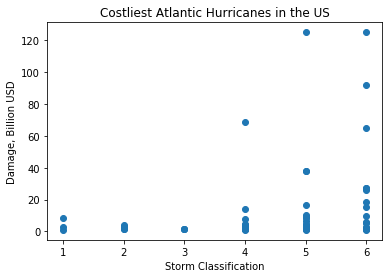

In [5]:
# Quick visualization of storm category vs damage
plt.scatter(storms.peak_category, storms.damage_busd)
plt.xlabel('Storm Classification')
plt.ylabel('Damage, Billion USD')
plt.title('Costliest Atlantic Hurricanes in the US')

# RECALL: Hurricane Categories are their value += 1,
# storms are 1, depressions are 0

Moving forward, I'm going to pickle the data frame so that I can export it to my Jupyter Notebook going through the NOAA HURDAT2 data to match up these billion dollar storms.  

I'm also going to drop the references column before doing so, seeing as those numbers no longer point to any useful footnotes.

In [6]:
storms.drop(labels = ['references'], axis = 1, inplace = True)

In [7]:
storms.to_pickle('./billion_dollar_NA_storms.pkl')

I haven't had much success finding the database that the NOAA uses to store all of those costs. With that in mind, I think I may be able to scrape the needed costs from Wikipedia. Each year has a dedicated page for the North Atlantic Hurricanes, most of which cites the NOAA's individual reports on the storm. Of special interest is a table at the bottom of every year's article that lists the significant developments:
* Storm name
* Dates active
* Storm category at peak intensity
* Max 1 min. wind, mph(kph)
* Min. pressure, (mbar)
* Damage (USD)
* Deaths

The column names are not always consistent, and some of the cost values are reported differently for different years, but I address dealing with those problems below. I go through a test case to show how I went about getting the data, then call all the years in bulk and define functions to clean and format the data.

In [8]:
year = '2015'
url = 'https://en.wikipedia.org/wiki/'+year+'_Atlantic_hurricane_season'
tables = pd.read_html(url, header = 0)
tables[-5].head(15)

,Stormname,Dates active,Storm category at peak intensity,Max 1-minwindmph (km/h),Min.press.(mbar),Areas affected,Damage (USD),Deaths,Refs
0,Ana,May 8 – 11,Tropical storm,60 (95),998.0,Southeastern United States (South Carolina),Minimal,1 (1),NaN
1,Bill,June 16 – 18,Tropical storm,60 (95),997.0,"Central America, Yucatán Peninsula, Southern U...",$17.9 million,8 (1),NaN
2,Claudette,July 13 – 14,Tropical storm,50 (85),1003.0,"East Coast of the United States, Newfoundland",None,None,NaN
3,Danny,August 18 – 24,Category 3 hurricane,125 (205),960.0,"Lesser Antilles, Puerto Rico",Minor,None,NaN
4,Erika,August 25 – 29,Tropical storm,50 (85),1001.0,"Lesser Antilles (Dominica), Greater Antilles, ...",$511.4 million,31 (4),NaN
5,Fred,August 30 – September 6,Category 1 hurricane,85 (140),986.0,"West Africa, Cape Verde",$2.5 million,9,NaN
6,Grace,September 5 – 9,Tropical storm,60 (95),1000.0,None,None,None,NaN
7,Henri,September 8 – 11,Tropical storm,50 (85),1003.0,None,None,None,NaN
8,Nine,September 16 – 19,Tropical depression,35 (55),1006.0,None,None,None,NaN
9,Ida,September 18 – 27,Tropical storm,50 (85),1001.0,None,None,None,NaN


In [9]:
# Identify where the desired table is relative to other page tables.
# Determine if it has a distinct shape.
for idx, table in enumerate(tables):
    print(table.shape)
    if table.shape[1] == 9:
        print(table.columns)

(19, 2)
(16, 6)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(0, 3)
(1, 7)
(14, 9)
Index(['Stormname', 'Dates active', 'Storm category at peak intensity',
       'Max 1-minwindmph (km/h)', 'Min.press.(mbar)', 'Areas affected',
       'Damage (USD)', 'Deaths', 'Refs'],
      dtype='object')
(0, 2)
(1, 1)
(7, 26)
(1, 12)


For 2015's page, there are 21 tables:
* The zero-th table is the summary stats table, top right.  
* The first table is the seasonal predictions table, 2nd on the right.  
* The 2nd table and following are the summary tables for each individual hurricane.  
* The 16th table is the one I'm looking for, $5^{th}$ from the end, and has 9 columns. I found that the table position changes from (-5) to (-6) in some years, but I can still use the number of columns to distinguish the desired table.
* The 17th table is empty.  
* The 18th table is a list to other pages for that decade.   
* The 19th table is a summary of that year's hurricanes.  
* The 20th is a table I can't identify. It may be citations.    

In [10]:
# For the table in question, we don't want the last two rows of summary stats
tables[-5].iloc[:-2].head(15)

,Stormname,Dates active,Storm category at peak intensity,Max 1-minwindmph (km/h),Min.press.(mbar),Areas affected,Damage (USD),Deaths,Refs
0,Ana,May 8 – 11,Tropical storm,60 (95),998.0,Southeastern United States (South Carolina),Minimal,1 (1),NaN
1,Bill,June 16 – 18,Tropical storm,60 (95),997.0,"Central America, Yucatán Peninsula, Southern U...",$17.9 million,8 (1),NaN
2,Claudette,July 13 – 14,Tropical storm,50 (85),1003.0,"East Coast of the United States, Newfoundland",None,None,NaN
3,Danny,August 18 – 24,Category 3 hurricane,125 (205),960.0,"Lesser Antilles, Puerto Rico",Minor,None,NaN
4,Erika,August 25 – 29,Tropical storm,50 (85),1001.0,"Lesser Antilles (Dominica), Greater Antilles, ...",$511.4 million,31 (4),NaN
5,Fred,August 30 – September 6,Category 1 hurricane,85 (140),986.0,"West Africa, Cape Verde",$2.5 million,9,NaN
6,Grace,September 5 – 9,Tropical storm,60 (95),1000.0,None,None,None,NaN
7,Henri,September 8 – 11,Tropical storm,50 (85),1003.0,None,None,None,NaN
8,Nine,September 16 – 19,Tropical depression,35 (55),1006.0,None,None,None,NaN
9,Ida,September 18 – 27,Tropical storm,50 (85),1001.0,None,None,None,NaN


### Grabbing Storm Cost Data
I now need to iteratively grab table data across as many years as possible. I've selected from 2017 back until 1967, at which point the tables cease to exist.  

The code follows several steps to extract and format the desired data:
* Grab all tables on the webpage
* Identify the desired dataframe by number of columns
* Clean the dataframe:
 * standardize column names
 * make sensical type conversions
* store cleaned dataframe of that year's storms
* concatenate annual storm data  

I was able to achieve this iteratively by exploiting the similarity in the url and table structure. There were two different sets of column names, although thankfully in both versions they contained the same data. All methods here are unstable, to the extent that changes in the table structure on Wikipedia may cause errors here.  

### Important Note on Damage Values
I noticed later on after doing some of my regressions that the damage values were strangely grouped. I found out that some tables use an inconsistent cost basis. The [1992 Table] (https://en.wikipedia.org/wiki/1991_Atlantic_hurricane_season), for example, lists Hurricane Andrew's damage estimate as 27300. Looking up Hurricane Andrew, we can tell that this value is 27300 million dollars. The 1991 uses the same million dollar basis, while tables from the 2010s use 'billion', 'million', and 'thousand' multipliers in the cells themselves, for example '27.3 billion'. There isn't a clear year from when this changes, so instead I've built a function to test the cost column to determine its format and then direct the parsing function to act appropriately.

Also, many storms list damage values as 'none', 'minor', 'minimal', 'unknown'. Because 'none' exists, I know that minor and minimal damage effectively corresponds to some small amount of damage that can't necessarily be reliably quantified. In many instances, these storms stayed offshore but sent in higher tides and rains that may have cut power or caused minor house, crop, property, etc. damage. Others made landfall and forced towns to evacuate, but did so in rural areas or in other countries where that damage couldn't be reliably assessed. I'm going to set all of these storm's damage values to 75001 USD and then create a dummy variable to indicated whether the damage value is imputed. This value allows them to be proportionate to any actual damages but to remain idenifiable. I may later try to bin all of these storms together by category and then impute the damage to the category's mean or median. The same trends appear in 'unknown' damage storms, and so they are also assigned this value.
Other strange cases that the parser doesn't address will be given the value 75002 USD so that I know to impute them later, and that they were an anomaly.

I'm going to test the method on year 1992, then expand to the whole set that I'm interested in once the kinks are worked out.  

Cross check also on 2001, 1988. Currently getting 'NaN' values in the damages and deaths column. May be due to the citation remover.

In [11]:
def clean_storm_data(dataframe):
    """
    Accepts a pandas dataframe of data scraped from Wikipedia.
    Renames columns and converts data for consistency across different naming conventions
    
    Output columns:
    ['name', 'dates_active', 'max_storm_cat', 'max_sust_wind',
    'min_p', 'damage_USD', 'deaths']
    """
    # Not mutating imported table, may need to compare the two later.
    df = dataframe.copy(deep=True)
    
    df['name'] = df.name.apply(lambda x: x.strip().upper())
    df['dates_active'] = df.dates_active.apply(lambda x: x.strip())
    
    # replaceCat defined above.
    # Recall that hurricane categories are +=1 to leave 1 representing storms and 0 for depressions.
    df['max_storm_cat'] = df.max_storm_cat.apply(replaceCat)
    df['max_sust_wind'] = df.max_sust_wind.apply(v_to_num)
    df['min_p'] = df.min_p.apply(p_to_num)
    
    #Damage extraction
    #print(good_table)
    dmg_basis_flag = get_cost_basis(df.damage_USD)
    #dmg_basis_flag = True
    df['damage_USD'] = df.damage_USD.apply(
        lambda value: parse_damage(value,dmg_basis_flag))
    # Flag all approximated/imputed damage values, convert from bool to int for dummy variable
    df['damage_imputed'] = pd.Series(
        (df['damage_USD'] == 75001.0) |(df['damage_USD'] == 75002.0), dtype = np.int32) 
    
    df['deaths'] = df.deaths.apply(parse_deaths)
    
    return df

def get_cost_basis(damage_series):
    '''
    Returns True if the series of damage values is using a million dollars as the base damage.
    Parameter: series-like iterable container:
    Return: True if million-dollar-basis, False if not
        ['None', '0.2', 'None'] -> True
        ['None', '≥ $200 thousand', 'None'] -> False
    '''
    for item in damage_series:
        if re.search(r'billion|million|thousand', str(item).lower()):
            return False
    return True

def parse_damage(dmg_str, basis_flag):
    '''
    Accepts damage data as number or string and returns cleaned numeric value.
        dmg_str: str or num: damage data 
        basis_flag: bool: True if data's table uses 1 million dollars as base value
    Parameters
    Returns: float: numeric value: 
        '$1.2 Billion' or 1200 -> 1200000000
    '''    
    
    new_dmg = remove_citation(str(dmg_str).lower())
    new_dmg = str(dmg_str).lower()
    magnitude = {'thousand': 3, 'million':6, 'billion': 9}
    
    # Distill value and order of magnitude
    value = re.search(r'[0-9,.]+', new_dmg)
    magntd = re.search(r'billion|million|thousand', new_dmg)
    
    if magntd:
        mult = 10**magnitude[magntd.group()]
    else:
        mult = 1
    
    # Compute and return actual cost
    # If statements are very specific in order to identify anomalies in the data
    
    # Return appropriately sized noise for damages labeled 'minor' or 'minimal' or 'unknown'
    # the value is specific so that they can later be identifed for imputation
    if re.search(r'minor|minimal|unknown',new_dmg):
        return 75001.0
    elif value and basis_flag:
        return float(value.group().replace(',',''))*1000000
    elif value and not basis_flag:
        return float(value.group().replace(',',''))*mult
    elif new_dmg == 'none':
        return 0.0
    elif magntd and not value:
        # Deals with specific case where damage is cited as 'millions'
        # without a numeric value. Assign it the order of magnitude.
        return mult
    else:
        print('Error in damage parser. Relevant values:')
        print('year','in', 'no citations', 'multiple', 'value', 'million dollar basis')
        print(year, dmg_str, new_dmg, magntd, mult, value, basis_flag)
        #print whole column of damage values
        return 75002.0

def v_to_num(num_str):
    '''
    Accepts string of windspeeds in mph.
    Returns number value in knots.
    '''
    val = re.search(r'[0-9]+', str(num_str))
    
    # 1 kt is 0.868976 of a mph
    if val:
        return float(val.group())*0.868976
    else:
        return None
    
def p_to_num(num_str):
    '''
    Accepts string of pressures in hPa.
    Returns number value in mbar.
    '''
    val = re.search(r'[0-9]+', str(num_str))
    
    if val:
        return float(val.group())
    else:
        return None
    
def parse_deaths(num_str):
    '''
    Determines total deaths associated with any given storm.
    Accepts a string containing either 'None' or two numbers in parenthesis.
        '4 (1)[9][09][10][11]'
    Returns sum of equivalent numeric values.
        4 + 1 = 5
    '''
    without_citation = remove_citation(str(num_str).lower())
    #without_citation = num_str
    nums = re.findall(r'[0-9]+', without_citation)
    return np.sum([float(value) for value in nums])

def remove_citation(with_citation):
    '''
     Removes '[...]' style citations from input strings.
     Parameter: string: example no. of hurricane deaths:
         '4 (1)[9][09][10][11]'
     Return: string: '4 (1)'
     '''
    #Converting input to string as a safeguard against bad input
    return re.sub(r'(\[\w+\])+', '', str(with_citation))

In [23]:
'''          Testing scrubbing process for a single year        '''

year = '1980'
url = 'https://en.wikipedia.org/wiki/'+year+'_Atlantic_hurricane_season'

#Possible parameters to fix read-in NaN's: converters,
tables = pd.read_html(url, header = 0, converters={'Damage(USD)':str, 'Deaths':str})
column_names = ['name', 'dates_active', 'max_storm_cat', 'max_sust_wind',
    'min_p', 'areas_affected', 'damage_USD', 'deaths', 'refs']

# Find the table with 9 columns
good_table = pd.DataFrame()
for table in tables:
    if len(table.columns) == 9:
        print(table) #Activate to see what pandas read in
        print(table.columns)
        good_table = table.iloc[:-2,:]
        
        # Rename columns to desired valuea, add year column for matching
        good_table.columns = column_names
        good_table['year'] = [year]*good_table.shape[0]
        
        # Send dataframe to be formatted consistently
        cleaned_df = clean_storm_data(good_table)
        print(cleaned_df.shape)
             
        break

# This dataframe contains the old and new columns, allows for side-by-side comparison
cleaned_df.head(20)

            Stormname                 Dates active  \
0                 One            July 17 – July 21   
1               Allen         August 1 – August 11   
2                Four        August 13 – August 17   
3              Bonnie        August 14 – August 19   
4             Charley        August 20 – August 25   
5                 Six        August 25 – August 29   
6             Georges    September 1 – September 8   
7            Danielle    September 4 – September 7   
8                Earl   September 4 – September 10   
9             Frances   September 6 – September 20   
10            Hermine  September 20 – September 26   
11               Ivan       October 4 – October 11   
12             Jeanne     November 8 – November 16   
13           Fourteen    November 12 – November 18   
14               Karl    November 25 – November 28   
15  Season Aggregates                          NaN   
16         18 systems        July 17 – November 28   

   Storm category at peak i

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,dates_active,max_storm_cat,max_sust_wind,min_p,areas_affected,damage_USD,deaths,refs,year,damage_imputed
0,ONE,July 17 – July 21,0,26.06928,1010.0,"Texas, Louisiana",4.000000e+06,0.0,NaN,1980,0
1,ALLEN,August 1 – August 11,6,165.10544,899.0,"Windward Islands, Hispaniola, Cuba, Cayman Isl...",1.570000e+09,290.0,NaN,1980,0
2,FOUR,August 13 – August 17,0,30.41416,1010.0,None,4.000000e+06,0.0,NaN,1980,0
3,BONNIE,August 14 – August 19,3,86.89760,975.0,none,4.000000e+06,0.0,NaN,1980,0
4,CHARLEY,August 20 – August 25,2,69.51808,989.0,North Carolina,4.000000e+06,7.0,NaN,1980,0
5,SIX,August 25 – August 29,0,30.41416,1009.0,none,4.000000e+06,0.0,NaN,1980,0
6,GEORGES,September 1 – September 8,2,69.51808,993.0,Newfoundland,4.000000e+06,0.0,NaN,1980,0
7,DANIELLE,September 4 – September 7,1,52.13856,1004.0,"Texas, Louisiana, Oklahoma, Mississippi",2.770000e+05,3.0,NaN,1980,0
8,EARL,September 4 – September 10,2,65.17320,985.0,none,4.000000e+06,0.0,NaN,1980,0
9,FRANCES,September 6 – September 20,4,99.93224,958.0,Cape Verde,4.000000e+06,0.0,NaN,1980,0


In [13]:
# Exploit consistency in url and table structure to go year by year and get all the data I can.
# The tables stop existing in 1967 so I'll collect up until that point.
good_tables = []
years = [str(year) for year in range(2017, 1967, -1)]

# Store column headers. On subsequent runs I'll code up a bit to clean the headers,
# however I need to what they are to set up the regular expression syntax.
column_headers = collections.defaultdict(list)

for year in years:
    url = 'https://en.wikipedia.org/wiki/'+year+'_Atlantic_hurricane_season'
    tables = pd.read_html(url, header = 0)
    
    # Find the table with 9 columns, clean it
    good_table = pd.DataFrame()
    for table in tables:
        if len(table.columns) == 9:
            good_table = table.iloc[:-2,:]
            
            # Rename columns to desired valuea, add year column for matching
            good_table.columns = column_names
            good_table['year'] = [year]*good_table.shape[0]
            column_headers[tuple(good_table.columns)].append(year)
            
            # Send dataframe to be formatted consistently
            cleaned_df = clean_storm_data(good_table)
          
            break
    
    # Store the good table if it exists, # print error if it doesn't
    if len(good_table) != 0:
        good_tables.append(cleaned_df)
    else:
        print('Table error in year: '+year)

cost_data = pd.concat(good_tables).reset_index()
print(cost_data.shape)
print(cost_data.year.unique())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Error in damage parser. Relevant values:
year in no citations multiple value million dollar basis
2003 Moderate moderate None 1 None True
Error in damage parser. Relevant values:
year in no citations multiple value million dollar basis
2001 nan nan None 1 None True
Error in damage parser. Relevant values:
year in no citations multiple value million dollar basis
2001 nan nan None 1 None True
Error in damage parser. Relevant values:
year in no citations multiple value million dollar basis
2001 nan nan None 1 None True
Error in damage parser. Relevant values:
year in no citations multiple value million dollar basis
2001 nan nan None 1 None True
Error in damage parser. Relevant values:
year in no citations multiple value million dollar basis
2001 nan nan None 1 None True
Error in damage parser. Relevant values:
year in no citations multiple value million dollar basis
2001 nan nan None 1 None True
Error in damage parser. Relevant values:
year in no citations multiple value million dollar ba

In [14]:
# Remove redundant index column
cost_data.drop(labels = ['index', 'refs'], axis = 1, inplace = True)
cost_data.head()

,name,dates_active,max_storm_cat,max_sust_wind,min_p,areas_affected,damage_USD,deaths,year,damage_imputed
0,ARLENE,April 19 – 21,1,43.44880,990.0,None,0.0,0.0,2017,0
1,BRET,June 19 – 20,1,43.44880,1007.0,"Guyana, Venezuela, Trinidad and Tobago, Windwa...",3000000.0,2.0,2017,0
2,CINDY,June 20 – 23,1,52.13856,991.0,"Honduras, Belize, Cayman Islands, Yucatán Peni...",25000000.0,2.0,2017,0
3,FOUR,July 5 – 7,0,26.06928,1009.0,None,0.0,0.0,2017,0
4,DON,July 17 – 18,1,43.44880,1005.0,"Windward Islands, Barbados, Trinidad and Tobago",0.0,0.0,2017,0


In [15]:
cost_data[cost_data.year == '1983']

,name,dates_active,max_storm_cat,max_sust_wind,min_p,areas_affected,damage_USD,deaths,year,damage_imputed
527,ONE,July 23 – 28,0,30.41416,NaN,None,0.0,0.0,1983,0
528,TWO,July 27 – August 2,0,30.41416,NaN,None,0.0,0.0,1983,0
529,ALICIA,August 15 – 20,4,99.93224,962.0,"Eastern Texas, Louisiana",75002.0,0.0,1983,1
530,BARRY,August 23 – 29,2,69.51808,986.0,"United States Gulf Coast, Mexico",75001.0,0.0,1983,1
531,CHANTAL,September 10 – 15,2,65.17320,994.0,None,0.0,0.0,1983,0
532,SIX,September 19 – 21,0,30.41416,NaN,None,0.0,0.0,1983,0
533,DEAN,September 26 – 30,1,56.48344,999.0,United States East Coast,75001.0,0.0,1983,1


At this point, I'm running into a few errors through the Pandas read_html method. These matter most in the damage and deaths column. It's reading the columns in as a string, which is fine, however before doing that conversion to string it's converting the value to a NaN. This happens in the year 1983 in two ways:
* in the deaths column, when it converts '$3 billion' to 'NaN' then outputs it as a string
* in the pressure column, where it converts 'Not Specified' to 'Nan' then outputs it as a string, but also outputs the numeric values as a string with no problem  

Given time constrains, I don't think it's going to be efficient for me to re-write my web scraping apparatus in Beautiful Soup since I need to move on to numerical analysis of my data. For now, I'm aware of this happening in years where there are issues parsing the damage values:
* 1968, 69, 70, 71, 72, 82, 83, 84, 86, 87, 88, 2001, 2003  

Those are just the ones I'm aware of. This happens in 1983 for the pressure, damage, and deaths columns, where it converts 'Not Specified', '$3 billion', and '21' all to NaN THEN outputs them as strings. In all cases, those values have a different structure than the majority of the values in their respective column. From posts I've read online about similar issues, I think this has to do with what's happening under the hood when Pandas reads in HTML, even before I can give it a converters argument. Those damage values also need to be converted to present day dollars. For now, I'll take this as a lesson on the limitations of reading tables with mixed value structures/types using pandas. If doing this over again, I think I'd use Beautiful Soup to grab the table text then pass it to pandas.read_html. I'll follow [this article](https://roche.io/2016/05/scrape-wikipedia-with-python) as a guide when I get around to it, but for now I need to get my regression apparatus up and running.  

Later tonight I'll export my data as a .csv, manually enter values I read off Wikipedia, and then re-read it.

In [16]:
# Example of manual corrections
cost_data.loc[(cost_data.year=='1983')&(cost_data.name=='ALICIA'), 'deaths'] = 21
cost_data.loc[(cost_data.year=='1983')&(cost_data.name=='ALICIA'), 'damage_USD'] = 3000000000

In [17]:
cost_data.loc[(cost_data.year=='1983')&(cost_data.name=='ALICIA'), ['deaths', 'damage_USD']]

,deaths,damage_USD
529,21.0,3.000000e+09


In [18]:
cost_data.to_csv('./cost_data_with_errors.csv')

In [19]:
# Getting column types. Will then compare with what comes back out of csv
cost_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 10 columns):
name              818 non-null object
dates_active      818 non-null object
max_storm_cat     818 non-null int64
max_sust_wind     794 non-null float64
min_p             717 non-null float64
areas_affected    818 non-null object
damage_USD        818 non-null float64
deaths            818 non-null float64
year              818 non-null object
damage_imputed    818 non-null int32
dtypes: float64(4), int32(1), int64(1), object(4)
memory usage: 60.8+ KB


In [24]:
patched_cost_data = pd.read_csv('./cost_data_manual_patch.csv')
patched_cost_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 11 columns):
Unnamed: 0        818 non-null int64
name              818 non-null object
dates_active      818 non-null object
max_storm_cat     818 non-null int64
max_sust_wind     794 non-null float64
min_p             717 non-null float64
areas_affected    818 non-null object
damage_USD        818 non-null float64
deaths            818 non-null int64
year              818 non-null int64
damage_imputed    818 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 70.4+ KB


In [29]:
patched_cost_data.drop(labels='Unnamed: 0',axis=1, inplace=True)
patched_cost_data.head()

,name,dates_active,max_storm_cat,max_sust_wind,min_p,areas_affected,damage_USD,deaths,year,damage_imputed
0,ARLENE,April 19 – 21,1,43.44880,990.0,None,0.0,0,2017,0
1,BRET,June 19 – 20,1,43.44880,1007.0,"Guyana, Venezuela, Trinidad and Tobago, Windwa...",3000000.0,2,2017,0
2,CINDY,June 20 – 23,1,52.13856,991.0,"Honduras, Belize, Cayman Islands, Yucatán Peni...",25000000.0,2,2017,0
3,FOUR,July 5 – 7,0,26.06928,1009.0,None,0.0,0,2017,0
4,DON,July 17 – 18,1,43.44880,1005.0,"Windward Islands, Barbados, Trinidad and Tobago",0.0,0,2017,0


In [32]:
# Export cost data to pkl
cost_data.to_pickle('./hurricane_cost_data.pkl')
patched_cost_data.to_pickle('./hurricane_cost_data_patched.pkl')

In [34]:
### Testing Area for Pandas Read HTML parameters ###

year = '2001'
url = 'https://en.wikipedia.org/wiki/'+year+'_Atlantic_hurricane_season'

#Possible parameters to fix read-in NaN's: converters,
tables = pd.read_html(url, header = 0, converters={'Damage(USD)':str})

for table in tables:
    if table.shape[1] == 9:
        #print(table)
        print(table['Damage(USD)'])

0              NaN
1             None
2              NaN
3              NaN
4              NaN
5          Minimal
6             None
7              NaN
8          Minimal
9          Minimal
10             NaN
11         Minimal
12             NaN
13            None
14             NaN
15            None
16            None
17             NaN
18    11.3 billion
Name: Damage(USD), dtype: object


0              NaN
1             None
2              NaN
3              NaN
4              NaN
5          Minimal
6             None
7              NaN
8          Minimal
9          Minimal
10             NaN
11         Minimal
12             NaN
13            None
14             NaN
15            None
16            None
17             NaN
18    11.3 billion
Name: Damage(USD), dtype: object


In [22]:
remove_citation('None[4]')

'None'